/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(



📊 Model Evaluation Metrics:
MAE: 20.67
RMSE: 28.8
R2: 0.9

📈 3-Day AQI Forecast:
        date       pm25        pm10         no2         o3  predicted_aqi
0 2023-12-03  97.014241  159.194502  117.776278  28.291677     212.110001
1 2023-12-04  97.110295  159.243328  117.979208  28.317358     212.110001
2 2023-12-05  97.206349  159.292153  118.182138  28.343040     212.110001


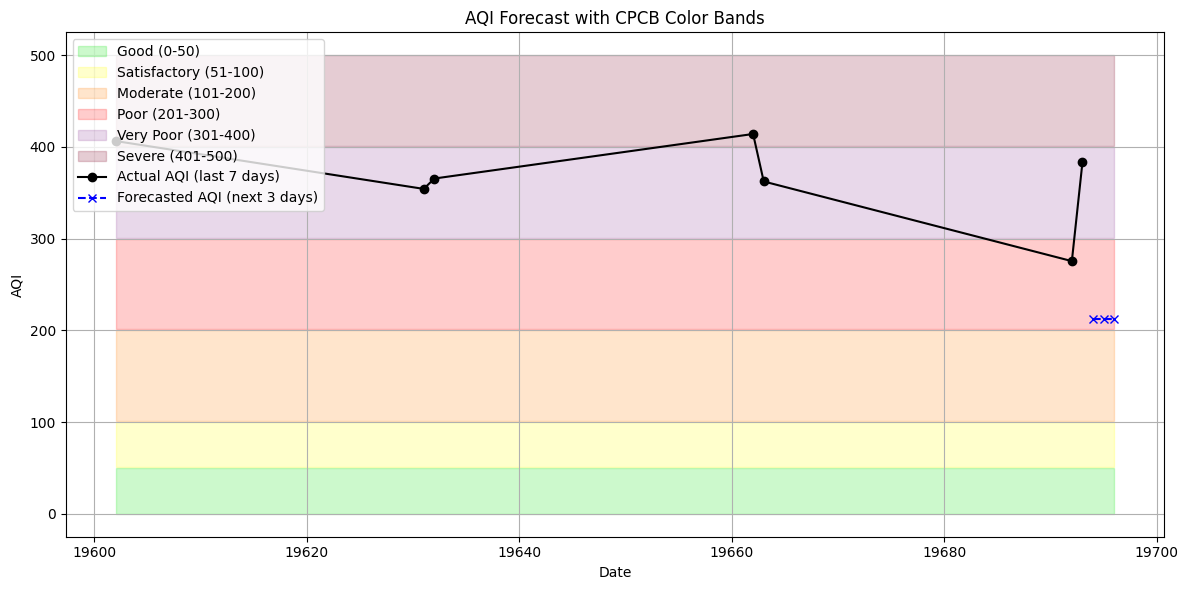

In [ ]:
import pandas as pd
import numpy as np
from datetime import timedelta
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# === 1. Load and Clean Data ===
def load_and_clean_data(file_path):
    df = pd.read_csv(file_path)
    df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")
    df = df.rename(columns={"from_date": "timestamp", "ozone": "o3", "pm2.5": "pm25"})
    df["timestamp"] = pd.to_datetime(df["timestamp"], errors='coerce')
    df = df[["timestamp", "pm25", "pm10", "no2", "o3"]].dropna()
    return df

# === 2. AQI Calculation Logic ===
BREAKPOINTS = {
    "pm25": [(0, 30, 0, 50), (31, 60, 51, 100), (61, 90, 101, 200),
             (91, 120, 201, 300), (121, 250, 301, 400), (251, 350, 401, 500)],
    "pm10": [(0, 50, 0, 50), (51, 100, 51, 100), (101, 250, 101, 200),
             (251, 350, 201, 300), (351, 430, 301, 400), (431, 530, 401, 500)],
    "no2": [(0, 40, 0, 50), (41, 80, 51, 100), (81, 180, 101, 200),
            (181, 280, 201, 300), (281, 400, 301, 400), (401, 500, 401, 500)],
    "o3": [(0, 50, 0, 50), (51, 100, 51, 100), (101, 168, 101, 200),
           (169, 208, 201, 300), (209, 748, 301, 400), (749, 800, 401, 500)]
}

def calculate_sub_index(pollutant, value):
    for low, high, index_low, index_high in BREAKPOINTS.get(pollutant, []):
        if low <= value <= high:
            return ((index_high - index_low) / (high - low)) * (value - low) + index_low
    return None

def add_aqi_column(df):
    df["aqi"] = df.apply(lambda row: max(filter(None, [
        calculate_sub_index("pm25", row["pm25"]),
        calculate_sub_index("pm10", row["pm10"]),
        calculate_sub_index("no2", row["no2"]),
        calculate_sub_index("o3", row["o3"]),
    ])), axis=1)
    return df

# === 3. Train AQI Prediction Model ===
def train_model(df):
    df_daily = df.set_index("timestamp").resample("D").mean().dropna()
    X = df_daily[["pm25", "pm10", "no2", "o3"]]
    y = df_daily["aqi"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)

    model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    metrics = {
        "MAE": round(mean_absolute_error(y_test, y_pred), 2),
        "RMSE": round(np.sqrt(mean_squared_error(y_test, y_pred)), 2),
        "R2": round(r2_score(y_test, y_pred), 2)
    }
    return model, df_daily, metrics

# === 4. Forecast Pollutants ===
def forecast_pollutants(df_daily, days=1):
    future_data = pd.DataFrame()
    for pollutant in ["pm25", "pm10", "no2", "o3"]:
        df_temp = df_daily[[pollutant]].reset_index()
        df_temp["day"] = np.arange(len(df_temp))
        model = LinearRegression()
        model.fit(df_temp[["day"]], df_temp[pollutant])
        future_days = np.arange(len(df_temp), len(df_temp) + days).reshape(-1, 1)
        preds = model.predict(future_days)
        future_data[pollutant] = preds
    future_data["date"] = [df_daily.index[-1] + timedelta(days=i+1) for i in range(days)]
    return future_data.set_index("date")

# === 5. Predict AQI for Future Days ===
def predict_future_aqi(model, forecast_df):
    forecast_df["predicted_aqi"] = np.round(model.predict(forecast_df[["pm25", "pm10", "no2", "o3"]]), 2)
    return forecast_df.reset_index()

# === 6. Main Pipeline with Plot ===
def main():
    file_path = "BandraKurlaComplexMumbaiIITM.csv"  # Update with your CSV path
    df = load_and_clean_data(file_path)
    df = add_aqi_column(df)
    model, df_daily, metrics = train_model(df)
    forecast_df = forecast_pollutants(df_daily, days=3)
    prediction_df = predict_future_aqi(model, forecast_df)

    print("\n📊 Model Evaluation Metrics:")
    for k, v in metrics.items():
        print(f"{k}: {v}")

    print("\n📈 3-Day AQI Forecast:")
    print(prediction_df)

    # === Plot with AQI color bands ===
    last_actual = df_daily["aqi"].iloc[-7:]
    forecasted = prediction_df.set_index("date")["predicted_aqi"]
    all_dates = last_actual.index.tolist() + forecasted.index.tolist()
    all_values = last_actual.tolist() + forecasted.tolist()

    # AQI Categories
    aqi_categories = [
        ("Good", 0, 50, "#00e400"),
        ("Satisfactory", 51, 100, "#ffff00"),
        ("Moderate", 101, 200, "#ff7e00"),
        ("Poor", 201, 300, "#ff0000"),
        ("Very Poor", 301, 400, "#8f3f97"),
        ("Severe", 401, 500, "#7e0023"),
    ]

    plt.figure(figsize=(12, 6))
    ax = plt.gca()

    # Add color bands
    for label, low, high, color in aqi_categories:
        ax.add_patch(Rectangle(
            (all_dates[0], low),
            all_dates[-1] - all_dates[0],
            high - low,
            color=color, alpha=0.2,
            label=f"{label} ({low}-{high})"
        ))

    # Plot AQI lines
    plt.plot(last_actual.index, last_actual.values, label="Actual AQI (last 7 days)", marker='o', color='black')
    plt.plot(forecasted.index, forecasted.values, label="Forecasted AQI (next 3 days)", marker='x', linestyle='--', color='blue')

    plt.title("AQI Forecast with CPCB Color Bands")
    plt.xlabel("Date")
    plt.ylabel("AQI")
    plt.grid(True)
    plt.legend(loc="upper left")
    plt.tight_layout()
    plt.show()

# === Run Script ===
if __name__ == "__main__":
    main()


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(



📈 Forecasted Pollutants and AQI for Next Day:
Date: 2023-12-03
PM2.5: 97.01, PM10: 159.19, NO2: 117.78, O3: 28.29
Predicted AQI: 221.52


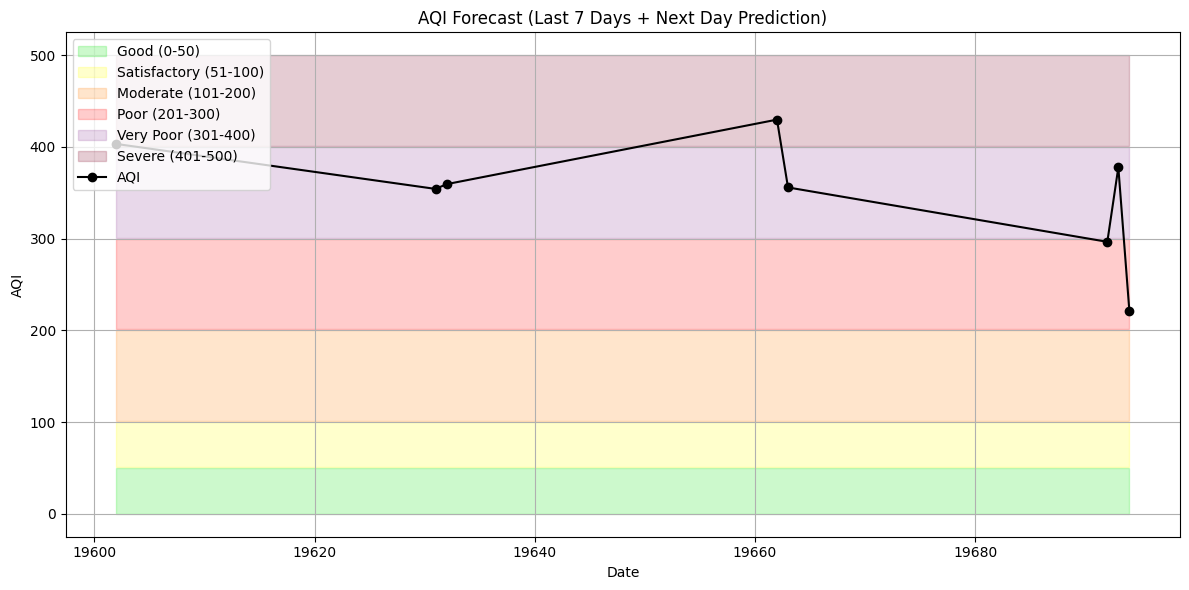

In [ ]:
import pandas as pd
import numpy as np
from datetime import timedelta
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# === 1. Load and Clean Data ===
def load_and_clean_data(file_path):
    df = pd.read_csv(file_path)
    df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")
    df = df.rename(columns={"from_date": "timestamp", "ozone": "o3", "pm2.5": "pm25"})
    df["timestamp"] = pd.to_datetime(df["timestamp"], errors='coerce')
    df = df[["timestamp", "pm25", "pm10", "no2", "o3"]].dropna()
    return df

# === 2. AQI Breakpoints ===
BREAKPOINTS = {
    "pm25": [(0, 30, 0, 50), (31, 60, 51, 100), (61, 90, 101, 200),
             (91, 120, 201, 300), (121, 250, 301, 400), (251, 350, 401, 500)],
    "pm10": [(0, 50, 0, 50), (51, 100, 51, 100), (101, 250, 101, 200),
             (251, 350, 201, 300), (351, 430, 301, 400), (431, 530, 401, 500)],
    "no2": [(0, 40, 0, 50), (41, 80, 51, 100), (81, 180, 101, 200),
            (181, 280, 201, 300), (281, 400, 301, 400), (401, 500, 401, 500)],
    "o3": [(0, 50, 0, 50), (51, 100, 51, 100), (101, 168, 101, 200),
           (169, 208, 201, 300), (209, 748, 301, 400), (749, 800, 401, 500)]
}

def calculate_sub_index(pollutant, value):
    for low, high, index_low, index_high in BREAKPOINTS.get(pollutant, []):
        if low <= value <= high:
            return ((index_high - index_low) / (high - low)) * (value - low) + index_low
    return None

def compute_aqi(pm25, pm10, no2, o3):
    sub_indices = [
        calculate_sub_index("pm25", pm25),
        calculate_sub_index("pm10", pm10),
        calculate_sub_index("no2", no2),
        calculate_sub_index("o3", o3),
    ]
    return round(max(filter(None, sub_indices)), 2)

# === 3. Forecast Next-Day Pollutant Values ===
def forecast_next_day_pollutants(df_daily):
    forecast_values = {}
    for pollutant in ["pm25", "pm10", "no2", "o3"]:
        df_temp = df_daily[[pollutant]].reset_index()
        df_temp["day"] = np.arange(len(df_temp))
        model = LinearRegression()
        model.fit(df_temp[["day"]], df_temp[pollutant])
        next_day = np.array([[len(df_temp)]])
        pred = model.predict(next_day)[0]
        forecast_values[pollutant] = round(pred, 2)
    forecast_values["date"] = df_daily.index[-1] + timedelta(days=1)
    forecast_values["aqi"] = compute_aqi(
        forecast_values["pm25"],
        forecast_values["pm10"],
        forecast_values["no2"],
        forecast_values["o3"]
    )
    return forecast_values

# === 4. Main Function with Plot ===
def main():
    file_path = "BandraKurlaComplexMumbaiIITM.csv"
    df = load_and_clean_data(file_path)
    df_daily = df.set_index("timestamp").resample("D").mean().dropna()

    forecast = forecast_next_day_pollutants(df_daily)
    print("\n📈 Forecasted Pollutants and AQI for Next Day:")
    print(f"Date: {forecast['date'].date()}")
    print(f"PM2.5: {forecast['pm25']}, PM10: {forecast['pm10']}, NO2: {forecast['no2']}, O3: {forecast['o3']}")
    print(f"Predicted AQI: {forecast['aqi']}")

    # === Plotting last 7 days + next day forecast ===
    last_actual = df_daily["pm25"].iloc[-7:]
    forecast_day = pd.Series([forecast["pm25"]], index=[forecast["date"]])

    full_series = pd.concat([last_actual, forecast_day])
    aqi_series = [compute_aqi(row["pm25"], row["pm10"], row["no2"], row["o3"]) for _, row in df_daily.iloc[-7:].iterrows()]
    aqi_series.append(forecast["aqi"])
    dates = list(df_daily.index[-7:]) + [forecast["date"]]

    # Plot AQI with color bands
    plt.figure(figsize=(12, 6))
    ax = plt.gca()

    aqi_categories = [
        ("Good", 0, 50, "#00e400"),
        ("Satisfactory", 51, 100, "#ffff00"),
        ("Moderate", 101, 200, "#ff7e00"),
        ("Poor", 201, 300, "#ff0000"),
        ("Very Poor", 301, 400, "#8f3f97"),
        ("Severe", 401, 500, "#7e0023"),
    ]

    for label, low, high, color in aqi_categories:
        ax.add_patch(Rectangle(
            (dates[0], low),
            dates[-1] - dates[0],
            high - low,
            color=color, alpha=0.2,
            label=f"{label} ({low}-{high})"
        ))

    plt.plot(dates, aqi_series, label="AQI", marker='o', color='black')
    plt.title("AQI Forecast (Last 7 Days + Next Day Prediction)")
    plt.xlabel("Date")
    plt.ylabel("AQI")
    plt.grid(True)
    plt.legend(loc="upper left")
    plt.tight_layout()
    plt.show()

# === Run Script ===
if __name__ == "__main__":
    main()


In [ ]:
import pandas as pd
import numpy as np
from datetime import timedelta
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import folium
from folium.plugins import HeatMap

# === 1. Setup location mapping (name → lat/lon) ===
LOCATION_COORDINATES = {
    "BKC": (119.0688, 72.8703),
    "BandraMPCB": (19.0418, 772.8653),
    "BoriValiEastIITM": (19.228825, 72.854118),
    "BoriValiEastMPCB": (19.2298,  72.8609),
    "AndheriEast": (19.1179, 72.8631) ,
    "VileParleWestMumbai" :(19.1071, 72.8368),
    "VasaiWestMumbai":(19.366636 , 72.816101),
   "SionMumbai":(19.0390, 72.8619),
    "Worli":(18.9986, 72.8174),
    "VileParleWestMumbai":(19.1071, 72.8368),
    "VasaiWestMumbai":(19.366636, 72.816101),
    "SiddharthNagarWorli":(18.9978, 72.8139),
    "PowaiMumbai":(19.1176, 72.9060),
    "NavyNagarColaba":(18.8980, 72.8131),
    "MulundWestMumbai":(19.1759, 72.9521),
    "MazgaonMumbai":(18.9596, 72.8459),
    "MaladWestMumbai":(19.1890, 72.8355),
    "KurlaMumbai":(19.0726, 72.8845),
    "KhindipadaBhandupWestMumbai":(19.1599, 72.9239),
    "KandivaliEastMumbai":(19.2005, 72.8737),
     "DeonarMumbai":(19.0447, 72.9103),
     "ColabaMumbai":(18.9067, 72.8147),
     "ChhatrapatiShivajiIntlAirport":(19.0902, 72.8628),
     "ChakalaAndheri":(19.1098, 72.8583)




}


# === 2. Load and Clean Data ===
def load_and_clean_data(file_path):
    df = pd.read_csv(file_path)
    df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")
    df = df.rename(columns={"from_date": "timestamp", "ozone": "o3", "pm2.5": "pm25"})
    df["timestamp"] = pd.to_datetime(df["timestamp"], errors='coerce')
    df = df[["timestamp", "pm25", "pm10", "no2", "o3"]].dropna()
    return df

# === 3. AQI Breakpoints ===
BREAKPOINTS = {
    "pm25": [(0, 30, 0, 50), (31, 60, 51, 100), (61, 90, 101, 200),
             (91, 120, 201, 300), (121, 250, 301, 400), (251, 350, 401, 500)],
    "pm10": [(0, 50, 0, 50), (51, 100, 51, 100), (101, 250, 101, 200),
             (251, 350, 201, 300), (351, 430, 301, 400), (431, 530, 401, 500)],
    "no2": [(0, 40, 0, 50), (41, 80, 51, 100), (81, 180, 101, 200),
            (181, 280, 201, 300), (281, 400, 301, 400), (401, 500, 401, 500)],
    "o3": [(0, 50, 0, 50), (51, 100, 51, 100), (101, 168, 101, 200),
           (169, 208, 201, 300), (209, 748, 301, 400), (749, 800, 401, 500)]
}

def calculate_sub_index(pollutant, value):
    for low, high, index_low, index_high in BREAKPOINTS.get(pollutant, []):
        if low <= value <= high:
            return ((index_high - index_low) / (high - low)) * (value - low) + index_low
    return None

def compute_aqi(pm25, pm10, no2, o3):
    sub_indices = [
        calculate_sub_index("pm25", pm25),
        calculate_sub_index("pm10", pm10),
        calculate_sub_index("no2", no2),
        calculate_sub_index("o3", o3),
    ]
    return round(max(filter(None, sub_indices)), 2)

# === 4. Forecast Pollutants for Next Day ===
def forecast_pollutants(df_daily):
    forecast_values = {}
    for pollutant in ["pm25", "pm10", "no2", "o3"]:
        df_temp = df_daily[[pollutant]].reset_index()
        df_temp["day"] = np.arange(len(df_temp))
        model = LinearRegression()
        model.fit(df_temp[["day"]], df_temp[pollutant])
        next_day = np.array([[len(df_temp)]])
        pred = model.predict(next_day)[0]
        forecast_values[pollutant] = round(pred, 2)
    forecast_values["aqi"] = compute_aqi(
        forecast_values["pm25"],
        forecast_values["pm10"],
        forecast_values["no2"],
        forecast_values["o3"]
    )
    return forecast_values

# === 5. Process All Locations ===
def process_all_locations(file_dict):
    results = []
    for location, filepath in file_dict.items():
        df = load_and_clean_data(filepath)
        df_daily = df.set_index("timestamp").resample("D").mean().dropna()
        forecast = forecast_pollutants(df_daily)
        forecast["location"] = location
        forecast["lat"], forecast["lon"] = LOCATION_COORDINATES[location]
        results.append(forecast)
    return pd.DataFrame(results)

# === 6. Plot Heatmap ===
def plot_heatmap(df):
    mumbai_center = [19.0760, 72.8777]
    fmap = folium.Map(location=mumbai_center, zoom_start=11)

    for _, row in df.iterrows():
        folium.CircleMarker(
            location=[row["lat"], row["lon"]],
            radius=10,
            color=None,
            fill=True,
            fill_opacity=0.7,
            fill_color=get_aqi_color(row["aqi"]),
            popup=f"{row['location']}: AQI {row['aqi']}"
        ).add_to(fmap)

    HeatMap(data=df[["lat", "lon", "aqi"]].values, radius=20).add_to(fmap)
    fmap.save("mumbai_aqi_heatmap.html")
    print("🗺️ Heatmap saved as 'mumbai_aqi_heatmap.html'")

def get_aqi_color(aqi):
    if aqi <= 50:
        return "#00e400"
    elif aqi <= 100:
        return "#ffff00"
    elif aqi <= 200:
        return "#ff7e00"
    elif aqi <= 300:
        return "#ff0000"
    elif aqi <= 400:
        return "#8f3f97"
    else:
        return "#7e0023"

# === 7. Main Execution ===
def main():
    files = {
        "BKC": "BandraKurlaComplexMumbaiIITM.csv",
        "BandraMPCB": "BandraMumbaiMPCB.csv",
        "BoriValiEastIITM": "BorivaliEastMumbaiIITM.csv",
        "BoriValiEastMPCB": "BorivaliEastMumbaiMPCB.csv",
        "AndheriEast": "ChakalaAndheriEastMumbaiIITM.csv",
        "VileParleWestMumbai":"VileParleWestMumbaiMPCB.csv",
        "VasaiWestMumbai":"VasaiWestMumbaiMPCB.csv",
        "SionMumbai" :"SionMumbaiMPCB.csv",
        "SiddharthNagarWorli" : "SiddharthNagarWorliMumbaiIITM.csv",
        "PowaiMumbai" :"PowaiMumbaiMPCB.csv",
        "NavyNagarColaba" :"NavyNagarColabaMumbaiIITM.csv",
        "MulundWestMumbai" : "MulundWestMumbaiMPCB.csv",
        "MazgaonMumbai" :"MazgaonMumbaiIITM.csv",
        "MaladWestMumbai":"MaladWestMumbaiIITM.csv",
        "KurlaMumbai":"KurlaMumbaiMPCB.csv",
        "KhindipadaBhandupWestMumbai":"KhindipadaBhandupWestMumbaiIITM.csv",
        "KandivaliEastMumbai":"KandivaliEastMumbaiMPCB.csv",
        "DeonarMumbai" :"DeonarMumbaiIITM.csv",
        "ColabaMumbai":"ColabaMumbaiMPCB.csv",
        "ChhatrapatiShivajiIntlAirport" :"ChhatrapatiShivajiIntlAirportT2MumbaiMPCB.csv",
        "ChakalaAndheri":"ChakalaAndheriEastMumbaiIITM.csv",


        "Worli": "WorliMumbaiMPCB.csv"
    }

    results_df = process_all_locations(files)

    print("\n📊 Next-Day AQI Forecast by Location:")
    print(results_df[["location", "pm25", "pm10", "no2", "o3", "aqi"]])

    plot_heatmap(results_df)

# === Run Script ===
if __name__ == "__main__":
    main()


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/


📊 Next-Day AQI Forecast by Location:
                         location   pm25    pm10     no2     o3     aqi
0                             BKC  97.01  159.19  117.78  28.29  221.52
1                      BandraMPCB  42.26  111.22   16.50  72.71  107.79
2                BoriValiEastIITM  53.75  146.69   39.04  30.91  131.36
3                BoriValiEastMPCB  48.60   89.77   10.26  34.71   89.77
4                     AndheriEast  74.73  114.66   74.38  37.50  147.87
5             VileParleWestMumbai  65.79  203.01   22.92  27.72  168.78
6                 VasaiWestMumbai  72.63  164.09   17.92  40.92  142.92
7                      SionMumbai  61.22  135.76   47.38  10.38  124.10
8             SiddharthNagarWorli  52.43   87.56   52.18  45.60   87.56
9                     PowaiMumbai  57.61  109.80   30.05  31.61  106.85
10                NavyNagarColaba  52.19  109.58   34.72  48.43  106.70
11               MulundWestMumbai  59.17  129.12   28.13  14.02  119.68
12                  Mazgao

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Fitting 5 folds for each of 384 candidates, totalling 1920 fits
✅ Best Parameters: {'colsample_bytree': 0.8, 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 0.8}

📊 Model Evaluation Metrics:
MAE: 18.02
RMSE: 22.61
R2: 0.94

📈 3-Day AQI Forecast vs CPCB Calculation:
        date  predicted_aqi  calculated_aqi       diff
0 2023-12-03     203.190002      221.531376 -18.341373
1 2023-12-04     203.190002      221.859284 -18.669282
2 2023-12-05     203.190002      222.187193 -18.997190


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


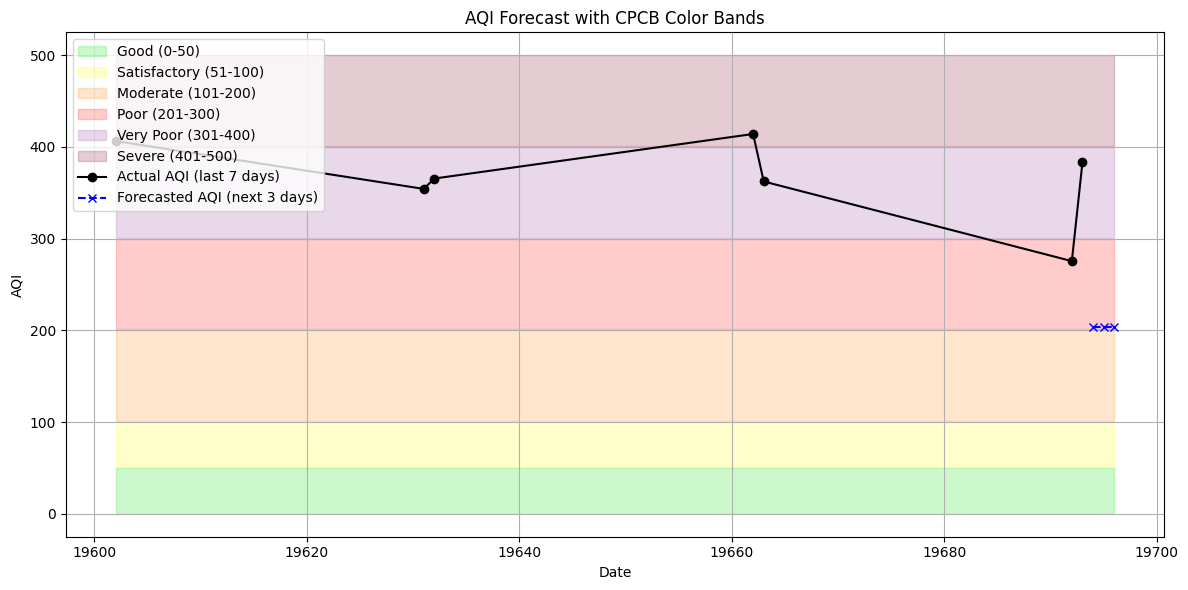

In [ ]:
import pandas as pd
import numpy as np
from datetime import timedelta
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# === 1. Load and Clean Data ===
def load_and_clean_data(file_path):
    df = pd.read_csv(file_path)
    df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")
    df = df.rename(columns={"from_date": "timestamp", "ozone": "o3", "pm2.5": "pm25"})
    df["timestamp"] = pd.to_datetime(df["timestamp"], errors='coerce')
    df = df[["timestamp", "pm25", "pm10", "no2", "o3"]].dropna()
    return df

# === 2. AQI Calculation Logic ===
BREAKPOINTS = {
    "pm25": [(0, 30, 0, 50), (31, 60, 51, 100), (61, 90, 101, 200),
             (91, 120, 201, 300), (121, 250, 301, 400), (251, 350, 401, 500)],
    "pm10": [(0, 50, 0, 50), (51, 100, 51, 100), (101, 250, 101, 200),
             (251, 350, 201, 300), (351, 430, 301, 400), (431, 530, 401, 500)],
    "no2": [(0, 40, 0, 50), (41, 80, 51, 100), (81, 180, 101, 200),
            (181, 280, 201, 300), (281, 400, 301, 400), (401, 500, 401, 500)],
    "o3": [(0, 50, 0, 50), (51, 100, 51, 100), (101, 168, 101, 200),
           (169, 208, 201, 300), (209, 748, 301, 400), (749, 800, 401, 500)]
}

def calculate_sub_index(pollutant, value):
    for low, high, index_low, index_high in BREAKPOINTS.get(pollutant, []):
        if low <= value <= high:
            return ((index_high - index_low) / (high - low)) * (value - low) + index_low
    return None

def calculate_aqi_from_pollutants(row):
    return max(filter(None, [
        calculate_sub_index("pm25", row["pm25"]),
        calculate_sub_index("pm10", row["pm10"]),
        calculate_sub_index("no2", row["no2"]),
        calculate_sub_index("o3", row["o3"]),
    ]))

def add_aqi_column(df):
    df["aqi"] = df.apply(calculate_aqi_from_pollutants, axis=1)
    return df

# === 3. Train AQI Prediction Model ===
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

def train_model(df):
    df_daily = df.set_index("timestamp").resample("D").mean().dropna()
    X = df_daily[["pm25", "pm10", "no2", "o3"]]
    y = df_daily["aqi"]

    # TimeSeriesSplit ensures time-aware validation
    tscv = TimeSeriesSplit(n_splits=5)

    param_grid = {
        'n_estimators': [100, 200],
        'learning_rate': [0.05, 0.1],
        'max_depth': [3, 5, 7],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0],
        'gamma': [0, 1],
        'reg_alpha': [0, 0.1],
        'reg_lambda': [1, 10]
    }

    xgb = XGBRegressor(random_state=42)
    grid = GridSearchCV(xgb, param_grid, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
    grid.fit(X, y)

    best_model = grid.best_estimator_

    print("✅ Best Parameters:", grid.best_params_)

    # Split again for test evaluation
    split_index = int(len(X) * 0.8)
    X_train, X_test = X[:split_index], X[split_index:]
    y_train, y_test = y[:split_index], y[split_index:]

    best_model.fit(X_train, y_train)
    y_pred = best_model.predict(X_test)

    metrics = {
        "MAE": round(mean_absolute_error(y_test, y_pred), 2),
        "RMSE": round(np.sqrt(mean_squared_error(y_test, y_pred)), 2),
        "R2": round(r2_score(y_test, y_pred), 2)
    }

    return best_model, df_daily, metrics


# === 4. Forecast Pollutants ===
def forecast_pollutants(df_daily, days=1):
    future_data = pd.DataFrame()
    for pollutant in ["pm25", "pm10", "no2", "o3"]:
        df_temp = df_daily[[pollutant]].reset_index()
        df_temp["day"] = np.arange(len(df_temp))
        model = LinearRegression()
        model.fit(df_temp[["day"]], df_temp[pollutant])
        future_days = np.arange(len(df_temp), len(df_temp) + days).reshape(-1, 1)
        preds = model.predict(future_days)
        future_data[pollutant] = preds
    future_data["date"] = [df_daily.index[-1] + timedelta(days=i+1) for i in range(days)]
    return future_data.set_index("date")

# === 5. Predict AQI for Future Days ===
def predict_future_aqi(model, forecast_df):
    forecast_df["predicted_aqi"] = np.round(model.predict(forecast_df[["pm25", "pm10", "no2", "o3"]]), 2)
    return forecast_df.reset_index()

# === 6. Main Pipeline with Plot and Comparison ===
def main():
    file_path = "BandraKurlaComplexMumbaiIITM.csv"  # Update with your CSV path
    df = load_and_clean_data(file_path)
    df = add_aqi_column(df)
    model, df_daily, metrics = train_model(df)
    forecast_df = forecast_pollutants(df_daily, days=3)
    prediction_df = predict_future_aqi(model, forecast_df)

    # Step: Calculate CPCB-style AQI for the forecasted pollutant values
    prediction_df["calculated_aqi"] = prediction_df.apply(calculate_aqi_from_pollutants, axis=1)

    # Step: Compare predicted vs calculated
    prediction_df["diff"] = prediction_df["predicted_aqi"] - prediction_df["calculated_aqi"]

    print("\n📊 Model Evaluation Metrics:")
    for k, v in metrics.items():
        print(f"{k}: {v}")

    print("\n📈 3-Day AQI Forecast vs CPCB Calculation:")
    print(prediction_df[["date", "predicted_aqi", "calculated_aqi", "diff"]])

    # === Plot AQI with Color Bands ===
    last_actual = df_daily["aqi"].iloc[-7:]
    forecasted = prediction_df.set_index("date")["predicted_aqi"]
    all_dates = last_actual.index.tolist() + forecasted.index.tolist()
    all_values = last_actual.tolist() + forecasted.tolist()

    aqi_categories = [
        ("Good", 0, 50, "#00e400"),
        ("Satisfactory", 51, 100, "#ffff00"),
        ("Moderate", 101, 200, "#ff7e00"),
        ("Poor", 201, 300, "#ff0000"),
        ("Very Poor", 301, 400, "#8f3f97"),
        ("Severe", 401, 500, "#7e0023"),
    ]

    plt.figure(figsize=(12, 6))
    ax = plt.gca()

    for label, low, high, color in aqi_categories:
        ax.add_patch(Rectangle(
            (all_dates[0], low),
            all_dates[-1] - all_dates[0],
            high - low,
            color=color, alpha=0.2,
            label=f"{label} ({low}-{high})"
        ))

    plt.plot(last_actual.index, last_actual.values, label="Actual AQI (last 7 days)", marker='o', color='black')
    plt.plot(forecasted.index, forecasted.values, label="Forecasted AQI (next 3 days)", marker='x', linestyle='--', color='blue')

    plt.title("AQI Forecast with CPCB Color Bands")
    plt.xlabel("Date")
    plt.ylabel("AQI")
    plt.grid(True)
    plt.legend(loc="upper left")
    plt.tight_layout()
    plt.show()

# === Run Script ===
if __name__ == "__main__":
    main()


<ipython-input-11-282cc1891f56>:56: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.resample("H").mean().dropna()



📊 Model Evaluation Metrics:
MAE: 12.88
RMSE: 25.80
R2 Score: 0.93

📈 Forecasted AQI vs Calculated:
                     predicted_aqi  calculated_aqi  difference
date                                                          
2023-12-02 16:00:00     220.344666      217.820919    2.523746


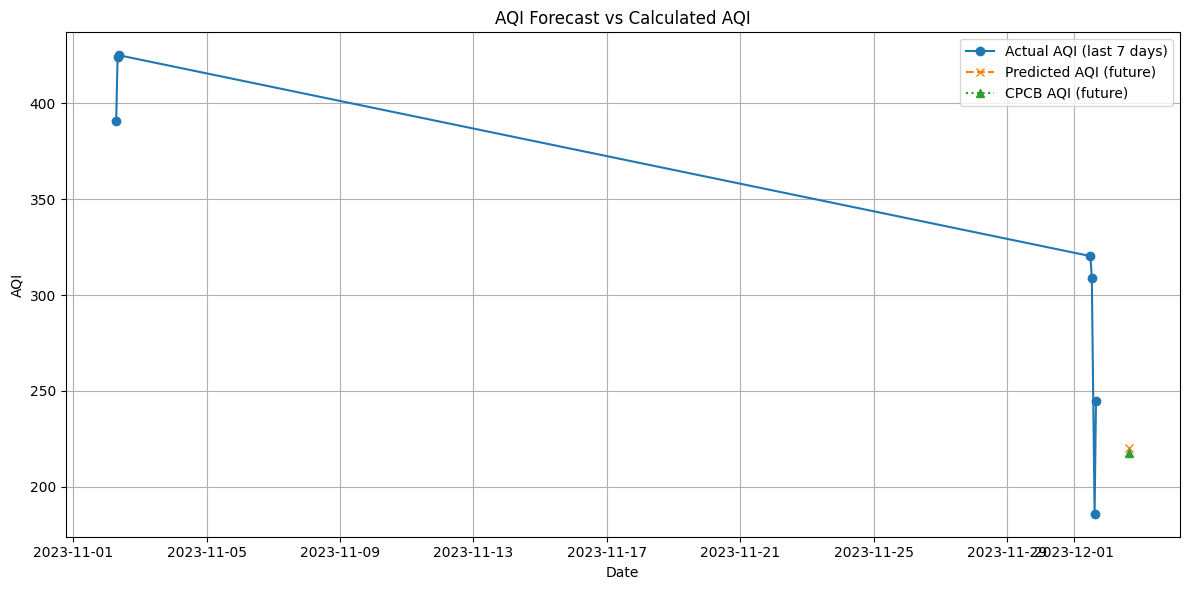

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from datetime import timedelta

# --- 1. Breakpoints for AQI Calculation ---
BREAKPOINTS = {
    "pm25": [(0, 30, 0, 50), (31, 60, 51, 100), (61, 90, 101, 200),
             (91, 120, 201, 300), (121, 250, 301, 400), (251, 350, 401, 500)],
    "pm10": [(0, 50, 0, 50), (51, 100, 51, 100), (101, 250, 101, 200),
             (251, 350, 201, 300), (351, 430, 301, 400), (431, 530, 401, 500)],
    "no2": [(0, 40, 0, 50), (41, 80, 51, 100), (81, 180, 101, 200),
            (181, 280, 201, 300), (281, 400, 301, 400), (401, 500, 401, 500)],
    "o3": [(0, 50, 0, 50), (51, 100, 51, 100), (101, 168, 101, 200),
           (169, 208, 201, 300), (209, 748, 301, 400), (749, 800, 401, 500)],
    "co": [(0, 1.0, 0, 50), (1.1, 2.0, 51, 100), (2.1, 10.0, 101, 200),
           (10.1, 17.0, 201, 300), (17.1, 34.0, 301, 400), (34.1, 50.0, 401, 500)],
    "so2": [(0, 40, 0, 50), (41, 80, 51, 100), (81, 380, 101, 200),
            (381, 800, 201, 300), (801, 1600, 301, 400), (1601, 2000, 401, 500)],
    "nh3": [(0, 200, 0, 50), (201, 400, 51, 100), (401, 800, 101, 200),
            (801, 1200, 201, 300), (1201, 1800, 301, 400), (1801, 2400, 401, 500)],
}

def calculate_sub_index(pollutant, value):
    for low, high, index_low, index_high in BREAKPOINTS.get(pollutant, []):
        if low <= value <= high:
            return ((index_high - index_low) / (high - low)) * (value - low) + index_low
    return None

def calculate_aqi(row):
    sub_indices = [
        calculate_sub_index(p, row[p])
        for p in BREAKPOINTS
        if p in row and pd.notnull(row[p])
    ]
    sub_indices = [s for s in sub_indices if s is not None]  # Filter out None
    return max(sub_indices) if sub_indices else None


# --- 2. Load, Clean, and Prepare Data ---
def load_data(file_path):
    df = pd.read_csv(file_path)
    df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")
    df = df.rename(columns={"from_date": "timestamp", "pm2.5": "pm25", "ozone": "o3"})
    df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
    df = df.dropna(subset=["timestamp"])

    pollutants = list(BREAKPOINTS.keys())
    df = df[["timestamp"] + [p for p in pollutants if p in df.columns]]
    df = df.dropna()
    df.set_index("timestamp", inplace=True)
    df = df.resample("H").mean().dropna()
    df["calculated_aqi"] = df.apply(calculate_aqi, axis=1)
    return df

# --- 3. Train AQI Prediction Model ---
def train_model(df):
    X = df[list(BREAKPOINTS.keys())]
    y = df["calculated_aqi"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    print("\n📊 Model Evaluation Metrics:")
    print(f"MAE: {mean_absolute_error(y_test, y_pred):.2f}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}")
    print(f"R2 Score: {r2_score(y_test, y_pred):.2f}")

    return model, df

# --- 4. Forecast Pollutants for Future Days ---
def forecast_pollutants(df, days=3):
    future_df = pd.DataFrame()
    last_date = df.index[-1]
    for pollutant in BREAKPOINTS.keys():
        y = df[pollutant].dropna()
        X = np.arange(len(y)).reshape(-1, 1)
        model = LinearRegression().fit(X, y)
        future_X = np.arange(len(y), len(y) + days).reshape(-1, 1)
        preds = model.predict(future_X)
        future_df[pollutant] = preds
    future_df["date"] = [last_date + timedelta(days=i+1) for i in range(days)]
    return future_df.set_index("date")

# --- 5. Predict AQI for Forecasted Pollutants ---
def predict_future_aqi(model, forecast_df):
    forecast_df["predicted_aqi"] = model.predict(forecast_df[list(BREAKPOINTS.keys())])
    forecast_df["calculated_aqi"] = forecast_df.apply(calculate_aqi, axis=1)
    forecast_df["difference"] = forecast_df["predicted_aqi"] - forecast_df["calculated_aqi"]
    return forecast_df

# --- 6. Plot Comparison ---
def plot_forecast(df_actual, df_future):
    plt.figure(figsize=(12, 6))
    plt.plot(df_actual.index[-7:], df_actual["calculated_aqi"].iloc[-7:], label="Actual AQI (last 7 days)", marker='o')
    plt.plot(df_future.index, df_future["predicted_aqi"], label="Predicted AQI (future)", marker='x', linestyle='--')
    plt.plot(df_future.index, df_future["calculated_aqi"], label="CPCB AQI (future)", marker='^', linestyle=':')
    plt.title("AQI Forecast vs Calculated AQI")
    plt.xlabel("Date")
    plt.ylabel("AQI")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# --- 7. Run Everything ---
def main():
    file_path = "BandraKurlaComplexMumbaiIITM.csv"  # Replace with actual file
    df = load_data(file_path)
    model, df = train_model(df)
    forecast_df = forecast_pollutants(df, days=1)
    results_df = predict_future_aqi(model, forecast_df)

    print("\n📈 Forecasted AQI vs Calculated:")
    print(results_df[["predicted_aqi", "calculated_aqi", "difference"]])

    plot_forecast(df, results_df)

if __name__ == "__main__":
    main()


In [ ]:
!pip install prophet


<ipython-input-10-2b8581f66040>:54: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.resample("H").mean().dropna()



📊 Model Evaluation Metrics:
MAE: 12.88
RMSE: 25.80
R2 Score: 0.93


<ipython-input-10-2b8581f66040>:75: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  future_index = pd.date_range(start=df.index[-1] + timedelta(hours=1), periods=hours, freq='H')
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnq42fdtb/8h9gwqa5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnq42fdtb/16x_v2cp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44827', 'data', 'file=/tmp/tmpnq42fdtb/8h9gwqa5.json', 'init=/tmp/tmpnq42fdtb/16x_v2cp.json', 'output', 'file=/tmp/tmpnq42fdtb/prophet_model29yinc3o/prophet_model-20250516202045.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:20:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:20:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/


📈 Forecasted AQI vs Calculated:
                     predicted_aqi  calculated_aqi  difference
timestamp                                                     
2023-12-01 17:00:00     420.395569      385.948999   34.446570
2023-12-01 18:00:00     420.395569      385.965937   34.429632
2023-12-01 19:00:00     420.395569      385.983157   34.412412
2023-12-01 20:00:00     420.395569      386.000661   34.394908
2023-12-01 21:00:00     420.395569      386.018449   34.377120


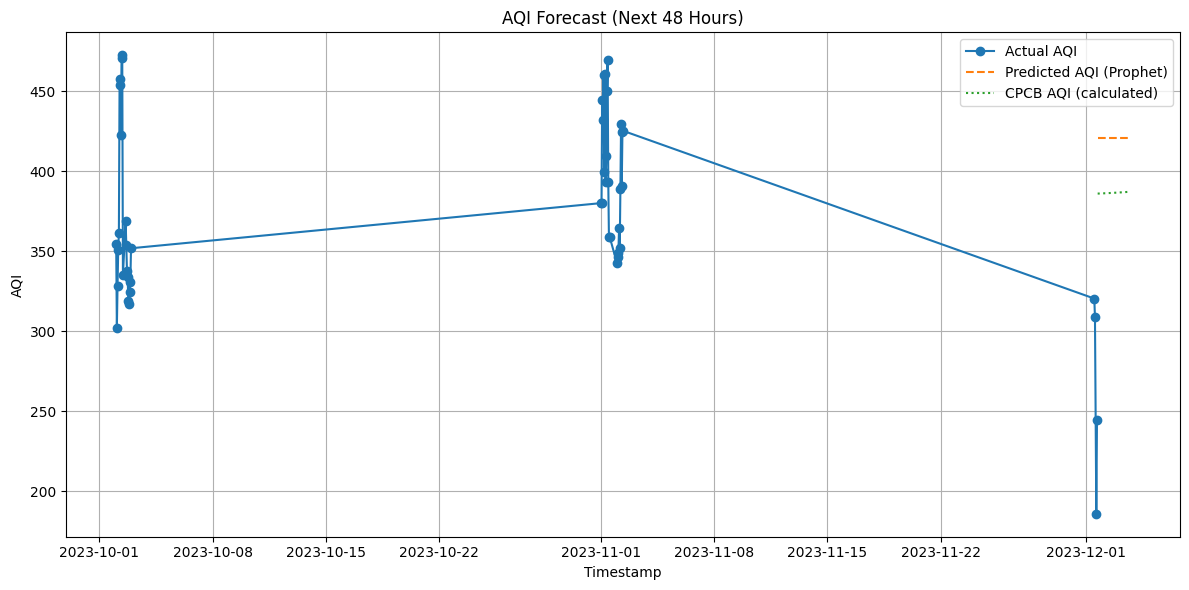

In [ ]:
import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from datetime import timedelta

# --- 1. Breakpoints for AQI Calculation ---
BREAKPOINTS = {
    "pm25": [(0, 30, 0, 50), (31, 60, 51, 100), (61, 90, 101, 200),
             (91, 120, 201, 300), (121, 250, 301, 400), (251, 350, 401, 500)],
    "pm10": [(0, 50, 0, 50), (51, 100, 51, 100), (101, 250, 101, 200),
             (251, 350, 201, 300), (351, 430, 301, 400), (431, 530, 401, 500)],
    "no2": [(0, 40, 0, 50), (41, 80, 51, 100), (81, 180, 101, 200),
            (181, 280, 201, 300), (281, 400, 301, 400), (401, 500, 401, 500)],
    "o3": [(0, 50, 0, 50), (51, 100, 51, 100), (101, 168, 101, 200),
           (169, 208, 201, 300), (209, 748, 301, 400), (749, 800, 401, 500)],
    "co": [(0, 1.0, 0, 50), (1.1, 2.0, 51, 100), (2.1, 10.0, 101, 200),
           (10.1, 17.0, 201, 300), (17.1, 34.0, 301, 400), (34.1, 50.0, 401, 500)],
    "so2": [(0, 40, 0, 50), (41, 80, 51, 100), (81, 380, 101, 200),
            (381, 800, 201, 300), (801, 1600, 301, 400), (1601, 2000, 401, 500)],
    "nh3": [(0, 200, 0, 50), (201, 400, 51, 100), (401, 800, 101, 200),
            (801, 1200, 201, 300), (1201, 1800, 301, 400), (1801, 2400, 401, 500)],
}

def calculate_sub_index(pollutant, value):
    for low, high, index_low, index_high in BREAKPOINTS.get(pollutant, []):
        if low <= value <= high:
            return ((index_high - index_low) / (high - low)) * (value - low) + index_low
    return None

def calculate_aqi(row):
    sub_indices = [
        calculate_sub_index(p, row[p])
        for p in BREAKPOINTS
        if p in row and pd.notnull(row[p])
    ]
    sub_indices = [s for s in sub_indices if s is not None]
    return max(sub_indices) if sub_indices else None

# --- 2. Load, Clean, and Prepare Data ---
def load_data(file_path):
    df = pd.read_csv(file_path)
    df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")
    df = df.rename(columns={"from_date": "timestamp", "pm2.5": "pm25", "ozone": "o3"})
    df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
    df = df.dropna(subset=["timestamp"])
    pollutants = list(BREAKPOINTS.keys())
    df = df[["timestamp"] + [p for p in pollutants if p in df.columns]]
    df = df.dropna()
    df.set_index("timestamp", inplace=True)
    df = df.resample("H").mean().dropna()
    df["calculated_aqi"] = df.apply(calculate_aqi, axis=1)
    return df

# --- 3. Train AQI Prediction Model ---
def train_model(df):
    X = df[list(BREAKPOINTS.keys())]
    y = df["calculated_aqi"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print("\n📊 Model Evaluation Metrics:")
    print(f"MAE: {mean_absolute_error(y_test, y_pred):.2f}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}")
    print(f"R2 Score: {r2_score(y_test, y_pred):.2f}")
    return model, df

# --- 4. Forecast Pollutants using Prophet ---
def forecast_pollutants(df, hours=48):
    future_df = pd.DataFrame()
    future_index = pd.date_range(start=df.index[-1] + timedelta(hours=1), periods=hours, freq='H')
    for pollutant in BREAKPOINTS.keys():
        try:
            ts = df[[pollutant]].dropna().reset_index()
            ts.columns = ['ds', 'y']
            model = Prophet(daily_seasonality=False, weekly_seasonality=False)
            model.fit(ts)
            future = model.make_future_dataframe(periods=hours, freq='H')
            forecast = model.predict(future)
            forecast_values = forecast[['ds', 'yhat']].set_index('ds').iloc[-hours:]
            forecast_values.columns = [pollutant]
            future_df = pd.concat([future_df, forecast_values], axis=1)
        except Exception as e:
            print(f"Could not forecast {pollutant}: {e}")
    future_df.index.name = 'timestamp'
    return future_df

# --- 5. Predict AQI from Forecasted Pollutants ---
def predict_future_aqi(model, forecast_df):
    forecast_df["predicted_aqi"] = model.predict(forecast_df[list(BREAKPOINTS.keys())])
    forecast_df["calculated_aqi"] = forecast_df.apply(calculate_aqi, axis=1)
    forecast_df["difference"] = forecast_df["predicted_aqi"] - forecast_df["calculated_aqi"]
    return forecast_df

# --- 6. Plot Comparison ---
def plot_forecast(df_actual, df_future):
    plt.figure(figsize=(12, 6))
    plt.plot(df_actual.index[-48:], df_actual["calculated_aqi"].iloc[-48:], label="Actual AQI", marker='o')
    plt.plot(df_future.index, df_future["predicted_aqi"], label="Predicted AQI (Prophet)", linestyle='--')
    plt.plot(df_future.index, df_future["calculated_aqi"], label="CPCB AQI (calculated)", linestyle=':')
    plt.title("AQI Forecast (Next 48 Hours)")
    plt.xlabel("Timestamp")
    plt.ylabel("AQI")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# --- 7. Run Everything ---
def main():
    file_path = "BandraKurlaComplexMumbaiIITM.csv"  # Replace with actual file
    df = load_data(file_path)
    model, df = train_model(df)
    forecast_df = forecast_pollutants(df, hours=48)
    results_df = predict_future_aqi(model, forecast_df)
    print("\n📈 Forecasted AQI vs Calculated:")
    print(results_df[["predicted_aqi", "calculated_aqi", "difference"]].head())
    plot_forecast(df, results_df)

if __name__ == "__main__":
    main()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from datetime import timedelta
import matplotlib.pyplot as plt
import folium
from folium.plugins import HeatMap
import os

# --- Breakpoints for AQI Calculation ---
BREAKPOINTS = {
    "pm25": [(0, 30, 0, 50), (31, 60, 51, 100), (61, 90, 101, 200),
             (91, 120, 201, 300), (121, 250, 301, 400), (251, 350, 401, 500)],
    "pm10": [(0, 50, 0, 50), (51, 100, 51, 100), (101, 250, 101, 200),
             (251, 350, 201, 300), (351, 430, 301, 400), (431, 530, 401, 500)],
    "no2": [(0, 40, 0, 50), (41, 80, 51, 100), (81, 180, 101, 200),
            (181, 280, 201, 300), (281, 400, 301, 400), (401, 500, 401, 500)],
    "o3": [(0, 50, 0, 50), (51, 100, 51, 100), (101, 168, 101, 200),
           (169, 208, 201, 300), (209, 748, 301, 400), (749, 800, 401, 500)],
    "co": [(0, 1.0, 0, 50), (1.1, 2.0, 51, 100), (2.1, 10.0, 101, 200),
           (10.1, 17.0, 201, 300), (17.1, 34.0, 301, 400), (34.1, 50.0, 401, 500)],
    "so2": [(0, 40, 0, 50), (41, 80, 51, 100), (81, 380, 101, 200),
            (381, 800, 201, 300), (801, 1600, 301, 400), (1601, 2000, 401, 500)],
    "nh3": [(0, 200, 0, 50), (201, 400, 51, 100), (401, 800, 101, 200),
            (801, 1200, 201, 300), (1201, 1800, 301, 400), (1801, 2400, 401, 500)],
}

def calculate_sub_index(pollutant, value):
    for low, high, index_low, index_high in BREAKPOINTS.get(pollutant, []):
        if low <= value <= high:
            return ((index_high - index_low) / (high - low)) * (value - low) + index_low
    return None

def calculate_aqi(row):
    sub_indices = [
        calculate_sub_index(p, row[p])
        for p in BREAKPOINTS if p in row and pd.notnull(row[p])
    ]
    sub_indices = [s for s in sub_indices if s is not None]
    return max(sub_indices) if sub_indices else None

def load_data(file_path):
    df = pd.read_csv(file_path)
    df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")
    df = df.rename(columns={"from_date": "timestamp", "pm2.5": "pm25", "ozone": "o3"})
    df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
    df = df.dropna(subset=["timestamp"])
    pollutants = list(BREAKPOINTS.keys())
    df = df[["timestamp"] + [p for p in pollutants if p in df.columns]]
    df = df.dropna()
    df.set_index("timestamp", inplace=True)
    df = df.resample("H").mean().dropna()
    df["calculated_aqi"] = df.apply(calculate_aqi, axis=1)
    return df

def train_model(df):
    X = df[list(BREAKPOINTS.keys())]
    y = df["calculated_aqi"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    metrics = {
        "MAE": round(mean_absolute_error(y_test, y_pred), 2),
        "RMSE": round(np.sqrt(mean_squared_error(y_test, y_pred)), 2),
        "R2": round(r2_score(y_test, y_pred), 2)
    }
    return model, metrics


def forecast_pollutants(df, days=1):
    future_df = pd.DataFrame()
    last_date = df.index[-1]
    for pollutant in BREAKPOINTS.keys():
        y = df[pollutant].dropna()
        X = np.arange(len(y)).reshape(-1, 1)
        reg = LinearRegression().fit(X, y)
        future_X = np.arange(len(y), len(y) + days).reshape(-1, 1)
        preds = reg.predict(future_X)
        future_df[pollutant] = preds
    future_df["timestamp"] = [last_date + timedelta(days=i+1) for i in range(days)]
    return future_df.set_index("timestamp")

def run_location(file_path, lat, lon, location_name):
    df = load_data(file_path)
    model, metrics = train_model(df)
    forecast_df = forecast_pollutants(df, days=1)
    forecast_df["predicted_aqi"] = model.predict(forecast_df[list(BREAKPOINTS.keys())])
    forecast_df["calculated_aqi"] = forecast_df.apply(calculate_aqi, axis=1)
    forecast_df["difference"] = forecast_df["predicted_aqi"] - forecast_df["calculated_aqi"]
    forecast_df["location"] = location_name
    forecast_df["lat"] = lat
    forecast_df["lon"] = lon
    forecast_df["MAE"] = metrics["MAE"]
    forecast_df["RMSE"] = metrics["RMSE"]
    forecast_df["R2"] = metrics["R2"]
    return forecast_df


def main():
    locations = {
        "BKC": ("BandraKurlaComplexMumbaiIITM.csv", 19.0688, 72.8703),
        "Powai": ("PowaiMumbaiMPCB.csv", 19.1176, 72.9060),
        "Sion": ("SionMumbaiMPCB.csv", 19.0390, 72.8619),
        "Vasai": ("VasaiWestMumbaiMPCB.csv", 19.366636, 72.816101),
        "Worli": ("WorliMumbaiMPCB.csv", 18.9986, 72.8174),
    }

    results = []
    for name, (csv, lat, lon) in locations.items():
        if os.path.exists(csv):
            forecast = run_location(csv, lat, lon, name)
            results.append(forecast)
        else:
            print(f"❌ File not found: {csv}")

    if results:
        combined_df = pd.concat(results)
        combined_df.to_csv("mumbai_aqi_predictions.csv", index=True)

        heat_data = [
            [row["lat"], row["lon"], row["predicted_aqi"]]
            for _, row in combined_df.iterrows()
        ]

        mumbai_map = folium.Map(location=[19.07, 72.88], zoom_start=11)
        HeatMap(heat_data).add_to(mumbai_map)
        mumbai_map.save("mumbai_aqi_heatmap.html")

        print("✅ Heatmap saved as mumbai_aqi_heatmap.html")
        print("✅ CSV saved as mumbai_aqi_predictions.csv")


if __name__ == "__main__":
    main()


<ipython-input-13-f3e5fd60b040>:55: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.resample("H").mean().dropna()
<ipython-input-13-f3e5fd60b040>:55: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.resample("H").mean().dropna()
<ipython-input-13-f3e5fd60b040>:55: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.resample("H").mean().dropna()
<ipython-input-13-f3e5fd60b040>:55: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.resample("H").mean().dropna()
<ipython-input-13-f3e5fd60b040>:55: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.resample("H").mean().dropna()


✅ Heatmap saved as mumbai_aqi_heatmap.html
✅ CSV saved as mumbai_aqi_predictions.csv


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from datetime import timedelta
import folium
from folium.plugins import HeatMap
import os

# --- AQI Breakpoints (CPCB) ---
BREAKPOINTS = {
    "pm25": [(0, 30, 0, 50), (31, 60, 51, 100), (61, 90, 101, 200),
             (91, 120, 201, 300), (121, 250, 301, 400), (251, 350, 401, 500)],
    "pm10": [(0, 50, 0, 50), (51, 100, 51, 100), (101, 250, 101, 200),
             (251, 350, 201, 300), (351, 430, 301, 400), (431, 530, 401, 500)],
    "no2": [(0, 40, 0, 50), (41, 80, 51, 100), (81, 180, 101, 200),
            (181, 280, 201, 300), (281, 400, 301, 400), (401, 500, 401, 500)],
    "o3": [(0, 50, 0, 50), (51, 100, 51, 100), (101, 168, 101, 200),
           (169, 208, 201, 300), (209, 748, 301, 400), (749, 800, 401, 500)],
    "co": [(0, 1.0, 0, 50), (1.1, 2.0, 51, 100), (2.1, 10.0, 101, 200),
           (10.1, 17.0, 201, 300), (17.1, 34.0, 301, 400), (34.1, 50.0, 401, 500)],
    "so2": [(0, 40, 0, 50), (41, 80, 51, 100), (81, 380, 101, 200),
            (381, 800, 201, 300), (801, 1600, 301, 400), (1601, 2000, 401, 500)],
    "nh3": [(0, 200, 0, 50), (201, 400, 51, 100), (401, 800, 101, 200),
            (801, 1200, 201, 300), (1201, 1800, 301, 400), (1801, 2400, 401, 500)],
}

def calculate_sub_index(pollutant, value):
    for low, high, ilow, ihigh in BREAKPOINTS.get(pollutant, []):
        if low <= value <= high:
            return ((ihigh - ilow) / (high - low)) * (value - low) + ilow
    return None

def calculate_aqi(row):
    indices = [
        calculate_sub_index(p, row[p])
        for p in BREAKPOINTS if p in row and pd.notnull(row[p])
    ]
    return max([i for i in indices if i is not None], default=None)

def load_data(file_path):
    df = pd.read_csv(file_path)
    df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")
    df = df.rename(columns={"from_date": "timestamp", "pm2.5": "pm25", "ozone": "o3"})
    df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
    df = df.dropna(subset=["timestamp"])
    df = df[["timestamp"] + [p for p in BREAKPOINTS if p in df.columns]]
    df = df.dropna().set_index("timestamp").resample("H").mean().dropna()
    df["calculated_aqi"] = df.apply(calculate_aqi, axis=1)
    return df

def train_model(df):
    X = df[list(BREAKPOINTS.keys())]
    y = df["calculated_aqi"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    metrics = {
        "MAE": round(mean_absolute_error(y_test, y_pred), 2),
        "RMSE": round(np.sqrt(mean_squared_error(y_test, y_pred)), 2),
        "R2": round(r2_score(y_test, y_pred), 2)
    }
    return model, metrics, X_test, y_test

def forecast_pollutants(df, days=1):
    future = pd.DataFrame()
    last_date = df.index[-1]
    for p in BREAKPOINTS:
        y = df[p].dropna()
        X = np.arange(len(y)).reshape(-1, 1)
        reg = LinearRegression().fit(X, y)
        pred = reg.predict(np.arange(len(y), len(y)+days).reshape(-1, 1))
        future[p] = pred
    future["timestamp"] = [last_date + timedelta(days=i+1) for i in range(days)]
    return future.set_index("timestamp")

def run_location(file_path, lat, lon, location_name):
    df = load_data(file_path)
    model, metrics, X_test, y_test = train_model(df)
    forecast = forecast_pollutants(df, days=1)
    forecast["predicted_aqi"] = model.predict(forecast[list(BREAKPOINTS.keys())])
    forecast["calculated_aqi"] = forecast.apply(calculate_aqi, axis=1)
    forecast["difference"] = forecast["predicted_aqi"] - forecast["calculated_aqi"]
    forecast["location"] = location_name
    forecast["lat"] = lat
    forecast["lon"] = lon
    forecast["MAE"] = metrics["MAE"]
    forecast["RMSE"] = metrics["RMSE"]
    forecast["R2"] = metrics["R2"]
    return forecast, X_test, y_test

def main():
    locations = {
        "BKC": ("BandraKurlaComplexMumbaiIITM.csv", 19.0688, 72.8703),
        "Powai": ("PowaiMumbaiMPCB.csv", 19.1176, 72.9060),
        "Sion": ("SionMumbaiMPCB.csv", 19.0390, 72.8619),
        "Vasai": ("VasaiWestMumbaiMPCB.csv", 19.3666, 72.8161),
        "Worli": ("WorliMumbaiMPCB.csv", 18.9986, 72.8174),
    }

    all_forecasts = []
    all_y_true = []
    all_y_pred = []

    for name, (path, lat, lon) in locations.items():
        if os.path.exists(path):
            forecast, X_test, y_test = run_location(path, lat, lon, name)
            all_forecasts.append(forecast)
            model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
            model.fit(X_test, y_test)
            y_pred = model.predict(X_test)
            all_y_true.extend(y_test)
            all_y_pred.extend(y_pred)
        else:
            print(f"❌ File not found: {path}")

    if all_forecasts:
        df = pd.concat(all_forecasts)

        print("\n📈 AQI Forecast for Next Day:")
        print(df[["location", "predicted_aqi", "calculated_aqi", "difference", "MAE", "RMSE", "R2"]].to_string(index=False))

        print("\n📊 Total Model Accuracy Across All Locations:")
        print(f"MAE  : {mean_absolute_error(all_y_true, all_y_pred):.2f}")
        print(f"RMSE : {np.sqrt(mean_squared_error(all_y_true, all_y_pred)):.2f}")
        print(f"R²   : {r2_score(all_y_true, all_y_pred):.2f}")

        # Save Heatmap
        mumbai_map = folium.Map(location=[19.07, 72.88], zoom_start=11)
        heat_data = [[row["lat"], row["lon"], row["predicted_aqi"]] for _, row in df.iterrows()]
        HeatMap(heat_data).add_to(mumbai_map)
        mumbai_map.save("mumbai_aqi_heatmap.html")
        print("✅ Heatmap saved as mumbai_aqi_heatmap.html")

if __name__ == "__main__":
    main()


<ipython-input-14-72e542dbd31f>:50: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.dropna().set_index("timestamp").resample("H").mean().dropna()
<ipython-input-14-72e542dbd31f>:50: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.dropna().set_index("timestamp").resample("H").mean().dropna()
<ipython-input-14-72e542dbd31f>:50: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.dropna().set_index("timestamp").resample("H").mean().dropna()
<ipython-input-14-72e542dbd31f>:50: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.dropna().set_index("timestamp").resample("H").mean().dropna()
<ipython-input-14-72e542dbd31f>:50: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.dropna().set_index("timestamp").


📈 AQI Forecast for Next Day:
location  predicted_aqi  calculated_aqi  difference   MAE  RMSE   R2
     BKC     220.344666      217.820919    2.523746 12.88 25.80 0.93
   Powai     109.705696      108.497312    1.208384  2.78  8.10 0.99
    Sion     124.003159      124.641987   -0.638829  4.72 14.23 0.96
   Vasai     156.236816      155.077231    1.159585  1.99  4.98 0.98
   Worli     110.459198      109.533002    0.926196  2.57  5.33 0.99

📊 Total Model Accuracy Across All Locations:
MAE  : 1.16
RMSE : 2.21
R²   : 1.00
✅ Heatmap saved as mumbai_aqi_heatmap.html


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from datetime import timedelta
import folium
from folium.plugins import HeatMap
from geopy.distance import geodesic
import os

# --- AQI Breakpoints (CPCB) ---
BREAKPOINTS = {
    "pm25": [(0, 30, 0, 50), (31, 60, 51, 100), (61, 90, 101, 200),
             (91, 120, 201, 300), (121, 250, 301, 400), (251, 350, 401, 500)],
    "pm10": [(0, 50, 0, 50), (51, 100, 51, 100), (101, 250, 101, 200),
             (251, 350, 201, 300), (351, 430, 301, 400), (431, 530, 401, 500)],
    "no2": [(0, 40, 0, 50), (41, 80, 51, 100), (81, 180, 101, 200),
            (181, 280, 201, 300), (281, 400, 301, 400), (401, 500, 401, 500)],
    "o3": [(0, 50, 0, 50), (51, 100, 51, 100), (101, 168, 101, 200),
           (169, 208, 201, 300), (209, 748, 301, 400), (749, 800, 401, 500)],
    "co": [(0, 1.0, 0, 50), (1.1, 2.0, 51, 100), (2.1, 10.0, 101, 200),
           (10.1, 17.0, 201, 300), (17.1, 34.0, 301, 400), (34.1, 50.0, 401, 500)],
    "so2": [(0, 40, 0, 50), (41, 80, 51, 100), (81, 380, 101, 200),
            (381, 800, 201, 300), (801, 1600, 301, 400), (1601, 2000, 401, 500)],
    "nh3": [(0, 200, 0, 50), (201, 400, 51, 100), (401, 800, 101, 200),
            (801, 1200, 201, 300), (1201, 1800, 301, 400), (1801, 2400, 401, 500)],
}

def calculate_sub_index(pollutant, value):
    for low, high, ilow, ihigh in BREAKPOINTS.get(pollutant, []):
        if low <= value <= high:
            return ((ihigh - ilow) / (high - low)) * (value - low) + ilow
    return None

def calculate_aqi(row):
    indices = [calculate_sub_index(p, row[p]) for p in BREAKPOINTS if p in row and pd.notnull(row[p])]
    return max([i for i in indices if i is not None], default=None)

def load_data(file_path):
    df = pd.read_csv(file_path)
    df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")
    df = df.rename(columns={"from_date": "timestamp", "pm2.5": "pm25", "ozone": "o3"})
    df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
    df = df.dropna(subset=["timestamp"])
    df = df[["timestamp"] + [p for p in BREAKPOINTS if p in df.columns]]
    df = df.dropna().set_index("timestamp").resample("H").mean().dropna()
    df["calculated_aqi"] = df.apply(calculate_aqi, axis=1)
    return df

def train_model(df):
    X = df[list(BREAKPOINTS.keys())]
    y = df["calculated_aqi"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
    model.fit(X_train, y_train)
    return model

def forecast_pollutants(df, days=1):
    future = pd.DataFrame()
    last_date = df.index[-1]
    for p in BREAKPOINTS:
        y = df[p].dropna()
        X = np.arange(len(y)).reshape(-1, 1)
        reg = LinearRegression().fit(X, y)
        pred = reg.predict(np.arange(len(y), len(y)+days).reshape(-1, 1))
        future[p] = pred
    future["timestamp"] = [last_date + timedelta(days=i+1) for i in range(days)]
    return future.set_index("timestamp")

def run_location(file_path, lat, lon, location_name):
    df = load_data(file_path)
    model = train_model(df)
    forecast = forecast_pollutants(df, days=1)
    forecast["predicted_aqi"] = model.predict(forecast[list(BREAKPOINTS.keys())])
    forecast["calculated_aqi"] = forecast.apply(calculate_aqi, axis=1)
    forecast["location"] = location_name
    forecast["lat"] = lat
    forecast["lon"] = lon
    return forecast

def main():
    # Known monitoring locations with file paths and coordinates
    locations = {
        "BKC": ("BandraKurlaComplexMumbaiIITM.csv", 19.0688, 72.8703),
        "Powai": ("PowaiMumbaiMPCB.csv", 19.1176, 72.9060),
        "Sion": ("SionMumbaiMPCB.csv", 19.0390, 72.8619),
        "Vasai": ("VasaiWestMumbaiMPCB.csv", 19.3666, 72.8161),
        "Worli": ("WorliMumbaiMPCB.csv", 18.9986, 72.8174),
    }

    # User enters any location (Location A)
    user_name = input("Enter your location name (e.g. Home): ")
    user_lat = float(input("Enter latitude (e.g. 19.10): "))
    user_lon = float(input("Enter longitude (e.g. 72.85): "))
    user_location = (user_name, user_lat, user_lon)

    # Run model per location
    forecasts = []
    for name, (csv_file, lat, lon) in locations.items():
        if os.path.exists(csv_file):
            forecast = run_location(csv_file, lat, lon, name)
            forecasts.append(forecast)
        else:
            print(f"❌ File not found: {csv_file}")

    if not forecasts:
        print("⚠️ No forecasts available.")
        return

    combined_df = pd.concat(forecasts)
    combined_df["distance_km"] = combined_df.apply(
        lambda row: geodesic((row["lat"], row["lon"]), (user_lat, user_lon)).km, axis=1
    )

    # Find 3 nearest stations
    nearest_3 = combined_df.sort_values("distance_km").head(3)
    best_aqi = nearest_3.sort_values("predicted_aqi").head(1)

    print("\n📍 Nearest 3 Stations to You:")
    print(nearest_3[["location", "predicted_aqi", "distance_km"]].to_string(index=False))

    print("\n✅ Suggested Cleanest Nearby Location:")
    print(best_aqi[["location", "predicted_aqi", "distance_km"]].to_string(index=False))

        # Map plotting
    m = folium.Map(location=[user_lat, user_lon], zoom_start=12)
    folium.Marker([user_lat, user_lon], tooltip="You Are Here", icon=folium.Icon(color='blue')).add_to(m)

    for _, row in nearest_3.iterrows():
        color = 'green' if row["location"] == best_aqi["location"].values[0] else 'orange'

        # Add marker for monitoring station
        folium.Marker(
            [row["lat"], row["lon"]],
            tooltip=f"{row['location']}: AQI {row['predicted_aqi']:.1f}",
            icon=folium.Icon(color=color)
        ).add_to(m)

        # Add route (blue line) from user location to station
        folium.PolyLine(
            locations=[(user_lat, user_lon), (row["lat"], row["lon"])],
            color='blue',
            weight=3,
            opacity=0.7,
            tooltip=f"Route to {row['location']}"
        ).add_to(m)

    # Save map
    m.save("recommended_cleanest_location_map.html")
    print("\n🗺️ Map saved as 'recommended_cleanest_location_map.html'")


if __name__ == "__main__":
    main()


Enter your location name (e.g. Home): home
Enter latitude (e.g. 19.10): 19.105
Enter longitude (e.g. 72.85): 72.856


<ipython-input-4-742c1dd132fd>:48: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.dropna().set_index("timestamp").resample("H").mean().dropna()
<ipython-input-4-742c1dd132fd>:48: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.dropna().set_index("timestamp").resample("H").mean().dropna()
<ipython-input-4-742c1dd132fd>:48: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.dropna().set_index("timestamp").resample("H").mean().dropna()
<ipython-input-4-742c1dd132fd>:48: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.dropna().set_index("timestamp").resample("H").mean().dropna()
<ipython-input-4-742c1dd132fd>:48: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.dropna().set_index("timestamp").resam


📍 Nearest 3 Stations to You:
location  predicted_aqi  distance_km
     BKC     220.344666     4.280359
   Powai     109.705696     5.442827
    Sion     124.003159     7.332075

✅ Suggested Cleanest Nearby Location:
location  predicted_aqi  distance_km
   Powai     109.705696     5.442827

🗺️ Map saved as 'recommended_cleanest_location_map.html'


In [1]:
pip install pandas numpy xgboost scikit-learn folium geopy openrouteservice


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from datetime import timedelta
import folium
from folium.plugins import HeatMap
from geopy.distance import geodesic
import openrouteservice
from openrouteservice import convert
import os

# --- Your OpenRouteService API Key ---
ORS_API_KEY = "5b3ce3597851110001cf6248c7de9e65bb2c4c15941aa7198568b6ec"
client = openrouteservice.Client(key=ORS_API_KEY)

# --- AQI Breakpoints (CPCB) ---
BREAKPOINTS = {
    "pm25": [(0, 30, 0, 50), (31, 60, 51, 100), (61, 90, 101, 200),
             (91, 120, 201, 300), (121, 250, 301, 400), (251, 350, 401, 500)],
    "pm10": [(0, 50, 0, 50), (51, 100, 51, 100), (101, 250, 101, 200),
             (251, 350, 201, 300), (351, 430, 301, 400), (431, 530, 401, 500)],
    "no2": [(0, 40, 0, 50), (41, 80, 51, 100), (81, 180, 101, 200),
            (181, 280, 201, 300), (281, 400, 301, 400), (401, 500, 401, 500)],
    "o3": [(0, 50, 0, 50), (51, 100, 51, 100), (101, 168, 101, 200),
           (169, 208, 201, 300), (209, 748, 301, 400), (749, 800, 401, 500)],
    "co": [(0, 1.0, 0, 50), (1.1, 2.0, 51, 100), (2.1, 10.0, 101, 200),
           (10.1, 17.0, 201, 300), (17.1, 34.0, 301, 400), (34.1, 50.0, 401, 500)],
    "so2": [(0, 40, 0, 50), (41, 80, 51, 100), (81, 380, 101, 200),
            (381, 800, 201, 300), (801, 1600, 301, 400), (1601, 2000, 401, 500)],
    "nh3": [(0, 200, 0, 50), (201, 400, 51, 100), (401, 800, 101, 200),
            (801, 1200, 201, 300), (1201, 1800, 301, 400), (1801, 2400, 401, 500)],
}

def calculate_sub_index(pollutant, value):
    for low, high, ilow, ihigh in BREAKPOINTS.get(pollutant, []):
        if low <= value <= high:
            return ((ihigh - ilow) / (high - low)) * (value - low) + ilow
    return None

def calculate_aqi(row):
    indices = [calculate_sub_index(p, row[p]) for p in BREAKPOINTS if p in row and pd.notnull(row[p])]
    return max([i for i in indices if i is not None], default=None)

def load_data(file_path):
    df = pd.read_csv(file_path)
    df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")
    df = df.rename(columns={"from_date": "timestamp", "pm2.5": "pm25", "ozone": "o3"})
    df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
    df = df.dropna(subset=["timestamp"])
    df = df[["timestamp"] + [p for p in BREAKPOINTS if p in df.columns]]
    df = df.dropna().set_index("timestamp").resample("H").mean().dropna()
    df["calculated_aqi"] = df.apply(calculate_aqi, axis=1)
    return df

def train_model(df):
    X = df[list(BREAKPOINTS.keys())]
    y = df["calculated_aqi"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
    model.fit(X_train, y_train)
    return model

def forecast_pollutants(df, days=1):
    future = pd.DataFrame()
    last_date = df.index[-1]
    for p in BREAKPOINTS:
        y = df[p].dropna()
        X = np.arange(len(y)).reshape(-1, 1)
        reg = LinearRegression().fit(X, y)
        pred = reg.predict(np.arange(len(y), len(y)+days).reshape(-1, 1))
        future[p] = pred
    future["timestamp"] = [last_date + timedelta(days=i+1) for i in range(days)]
    return future.set_index("timestamp")

def run_location(file_path, lat, lon, location_name):
    df = load_data(file_path)
    model = train_model(df)
    forecast = forecast_pollutants(df, days=1)
    forecast["predicted_aqi"] = model.predict(forecast[list(BREAKPOINTS.keys())])
    forecast["calculated_aqi"] = forecast.apply(calculate_aqi, axis=1)
    forecast["location"] = location_name
    forecast["lat"] = lat
    forecast["lon"] = lon
    return forecast

def main():
    # Known monitoring locations
    locations = {
        "BKC": ("BandraKurlaComplexMumbaiIITM.csv", 19.0688, 72.8703),
        "Powai": ("PowaiMumbaiMPCB.csv", 19.1176, 72.9060),
        "Sion": ("SionMumbaiMPCB.csv", 19.0390, 72.8619),
        "Vasai": ("VasaiWestMumbaiMPCB.csv", 19.3666, 72.8161),
        "Worli": ("WorliMumbaiMPCB.csv", 18.9986, 72.8174),
    }

    user_name = input("Enter your location name (e.g. Home): ")
    user_lat = float(input("Enter latitude (e.g. 19.10): "))
    user_lon = float(input("Enter longitude (e.g. 72.85): "))
    user_location = (user_name, user_lat, user_lon)

    forecasts = []
    for name, (csv_file, lat, lon) in locations.items():
        if os.path.exists(csv_file):
            forecast = run_location(csv_file, lat, lon, name)
            forecasts.append(forecast)
        else:
            print(f"❌ File not found: {csv_file}")

    if not forecasts:
        print("⚠️ No forecasts available.")
        return

    combined_df = pd.concat(forecasts)
    combined_df["distance_km"] = combined_df.apply(
        lambda row: geodesic((row["lat"], row["lon"]), (user_lat, user_lon)).km, axis=1
    )

    nearest_3 = combined_df.sort_values("distance_km").head(3)
    best_aqi = nearest_3.sort_values("predicted_aqi").head(1)

    print("\n📍 Nearest 3 Stations to You:")
    print(nearest_3[["location", "predicted_aqi", "distance_km"]].to_string(index=False))

    print("\n✅ Suggested Cleanest Nearby Location:")
    print(best_aqi[["location", "predicted_aqi", "distance_km"]].to_string(index=False))

    m = folium.Map(location=[user_lat, user_lon], zoom_start=12)
    folium.Marker([user_lat, user_lon], tooltip="You Are Here", icon=folium.Icon(color='blue')).add_to(m)

    for _, row in nearest_3.iterrows():
        color = 'green' if row["location"] == best_aqi["location"].values[0] else 'orange'
        folium.Marker(
            [row["lat"], row["lon"]],
            tooltip=f"{row['location']}: AQI {row['predicted_aqi']:.1f}",
            icon=folium.Icon(color=color)
        ).add_to(m)

        # Use OpenRouteService for road route
        coords = ((user_lon, user_lat), (row["lon"], row["lat"]))
        try:
            route = client.directions(coords)
            geometry = route['routes'][0]['geometry']
            decoded = convert.decode_polyline(geometry)
            route_coords = [(pt[1], pt[0]) for pt in decoded['coordinates']]
            folium.PolyLine(
                locations=route_coords,
                color='blue',
                weight=3,
                opacity=0.7,
                tooltip=f"Route to {row['location']}"
            ).add_to(m)
        except Exception as e:
            print(f"⚠️ Could not draw route to {row['location']}: {e}")

    m.save("recommended_cleanest_location_map.html")
    print("\n🗺️ Map saved as 'recommended_cleanest_location_map.html'")

if __name__ == "__main__":
    main()


Enter your location name (e.g. Home): Home
Enter latitude (e.g. 19.10): 18.9720
Enter longitude (e.g. 72.85): 73.0348


<ipython-input-3-edc34385f2a3>:54: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.dropna().set_index("timestamp").resample("H").mean().dropna()
<ipython-input-3-edc34385f2a3>:54: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.dropna().set_index("timestamp").resample("H").mean().dropna()
<ipython-input-3-edc34385f2a3>:54: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.dropna().set_index("timestamp").resample("H").mean().dropna()
<ipython-input-3-edc34385f2a3>:54: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.dropna().set_index("timestamp").resample("H").mean().dropna()
<ipython-input-3-edc34385f2a3>:54: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.dropna().set_index("timestamp").resam


📍 Nearest 3 Stations to You:
location  predicted_aqi  distance_km
    Sion     124.003159    19.657119
     BKC     220.344666    20.365148
   Powai     109.705696    21.061131

✅ Suggested Cleanest Nearby Location:
location  predicted_aqi  distance_km
   Powai     109.705696    21.061131

🗺️ Map saved as 'recommended_cleanest_location_map.html'
